# TEMPO Vignette: Trajectory Motif Detection After a Shared Perturbation

**T**rajectory **E**nrichment via **M**atrix **P**rofile **O**utcomes

---

## What is TEMPO?

TEMPO is a Python package for detecting trajectory motifs — recurring temporal
patterns — that are enriched in one outcome group relative to another in
longitudinal biological data. The core algorithm, **Harbinger analysis**, uses
the STUMPY matrix profile to find windows of time where cases share a conserved
pattern of change that controls do not.

## The problem TEMPO is designed to solve

Consider a cohort study in which all subjects receive the same perturbation —
a high-fructose diet, a vaccine, a transplant, an infection. When cases and
controls already differ substantially at baseline, that difference is itself
the finding — cross-sectional methods are sufficient and trajectory analysis
adds little. TEMPO is designed for the harder and more interesting problem:
cases and controls look the same at baseline, but only some go on to develop
the outcome. The signal is not in who was different to begin with; it is in
who changed differently after the perturbation, and when.

Standard analyses compare groups at individual timepoints and ask "is this
feature different between cases and controls right now?" They miss the
*shape* of the response: the timing, the rate of change, the pattern of
return to baseline or sustained elevation. TEMPO asks a different question:
**which features followed a distinctive temporal trajectory in cases, and when
did that trajectory diverge from controls?**

A concrete example: in a dietary intervention study, mice receiving a
high-fructose diet all start with identical gut microbiota composition.
Over the following weeks, all animals' compositions shift in response to the
diet. But a subset of animals go on to develop diabetes — and TEMPO can
identify which features showed a distinctive pattern of change in those
animals *before* the clinical outcome was apparent, and pinpoint the window
of time when that divergence occurred.

## What this vignette covers

We walk through a complete Harbinger analysis on a bundled example dataset:
40 subjects (15 cases, 25 controls) measured over 12 timepoints across 15
compositional features. All subjects share the same baseline; 15 go on to
develop the outcome of interest. Three features carry a planted trajectory
motif in the case group between timepoints 3 and 8. Our goal is to recover
those features and that window from the data alone.

The workflow is: **load → explore → Harbinger (raw data) → visualise →
statistical follow-up → evaluate against ground truth**. CLR transformation is
applied separately for visualization, where it makes the case/control divergence
more apparent, but Harbinger itself runs on the raw proportions (see section 3).

## Source code and documentation

GitHub: [https://github.com/cbumby17/TEMPO](https://github.com/cbumby17/TEMPO)


---
## 1  Setup

We import `tempo` and a few standard libraries, then load the bundled example
dataset with a single call to `tempo.load_example_data()`. The function returns
a long-format DataFrame — one row per (subject, timepoint, feature) combination
— and populates `df.attrs` with the ground truth metadata embedded at simulation
time. In a real dataset `df.attrs` would not carry ground truth, but here it
lets us verify our results at the end.

The `outcome` column uses 1 for cases (subjects who developed the outcome) and
0 for controls (subjects who did not). Both groups received the same perturbation
and start from equivalent baselines; what TEMPO is looking for is divergence in
their feature trajectories after the perturbation.


In [ ]:
import os
os.environ['KMP_WARNINGS'] = 'FALSE'  # suppress OpenMP info messages from STUMPY

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tempo
from tempo import simulate

sns.set_theme(style='whitegrid', palette='muted')

# Load the bundled example dataset
df = tempo.load_example_data()

print(f"Shape       : {df.shape}")
print(f"Subjects    : {df['subject_id'].nunique()} "
      f"({df[df['outcome']==1]['subject_id'].nunique()} cases, "
      f"{df[df['outcome']==0]['subject_id'].nunique()} controls)")
print(f"Timepoints  : {sorted(df['timepoint'].unique())}")
print(f"Features    : {df['feature'].nunique()}")
print()
print("Ground truth (df.attrs):")
for k, v in df.attrs.items():
    print(f"  {k}: {v}")
print()
df.head(6)

Shape       : (7200, 5)
Subjects    : 40 (15 cases, 25 controls)
Timepoints  : [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
Features    : 15

Ground truth (df.attrs):
  motif_features: ['feature_000', 'feature_001', 'feature_002']
  motif_window: (3, 8)
  n_cases: 15
  n_controls: 25
  motif_strength: 2.5



,subject_id,timepoint,feature,value,outcome
0,case_000,0,feature_000,0.000000,1
1,case_000,0,feature_001,0.091550,1
2,case_000,0,feature_002,0.059321,1
3,case_000,0,feature_003,0.053117,1
4,case_000,0,feature_004,0.099425,1
5,case_000,0,feature_005,0.056614,1


---
## 2  Exploring the Raw Data

Before running any algorithms it is worth looking at the raw trajectories. The
key thing to notice is that cases and controls start from the same baseline —
there is nothing to distinguish them at timepoint 0. The signal we are looking
for emerges *after* the perturbation: a subset of features in cases begins to
diverge from controls and then, in some features, returns toward baseline. This
is what a trajectory motif looks like: a pattern of change with a defined onset,
shape, and offset that is shared among cases but absent in controls.

The dataset uses **compositional measurements** — at every (subject, timepoint)
the 15 feature values sum to 1, representing proportions of a whole. This format
arises in any setting where you measure the relative breakdown of a system: cell
type fractions from a flow cytometry panel, relative metabolite abundances, or
proportional readouts where the total is constrained. The compositional constraint
creates statistical dependencies between features that must be handled before
running the matrix profile (see section 3).

We show individual trajectories for the three signal-carrying features and three
noise features, with the known motif window shaded in gold. Case/control
separation in raw proportion space is often subtle because renormalisation to
sum-to-1 partially absorbs any shift in individual features. The group mean ± SD
plot makes the pattern more apparent.


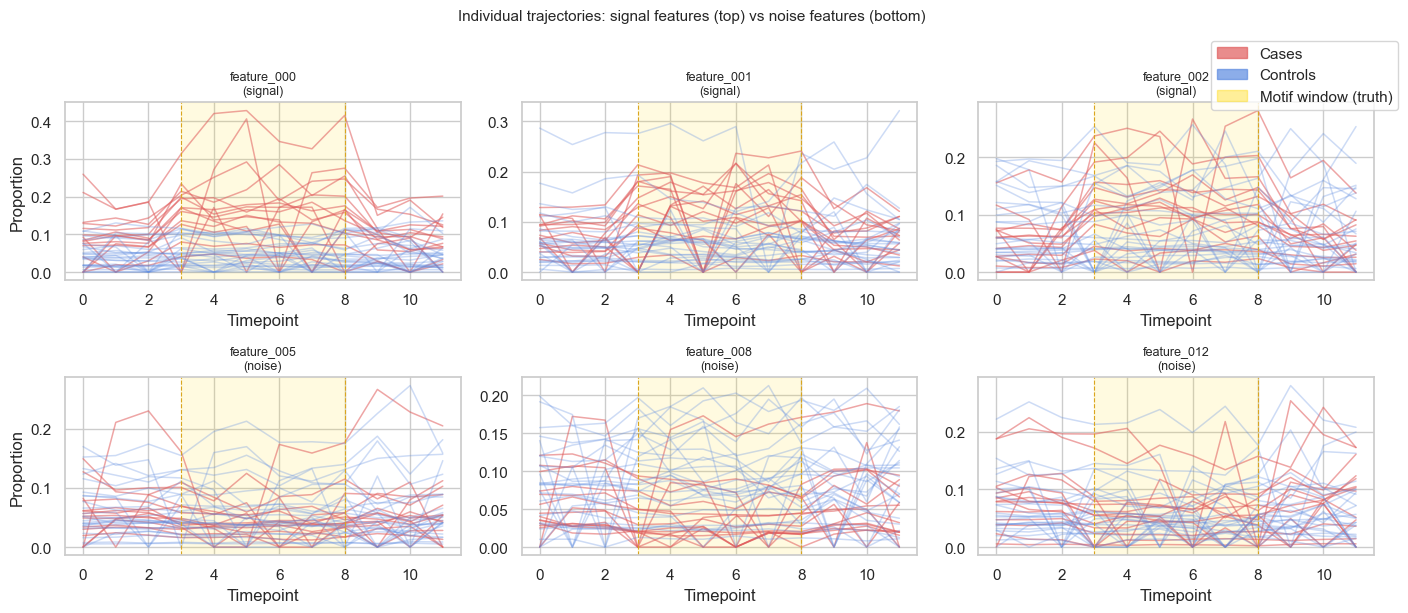

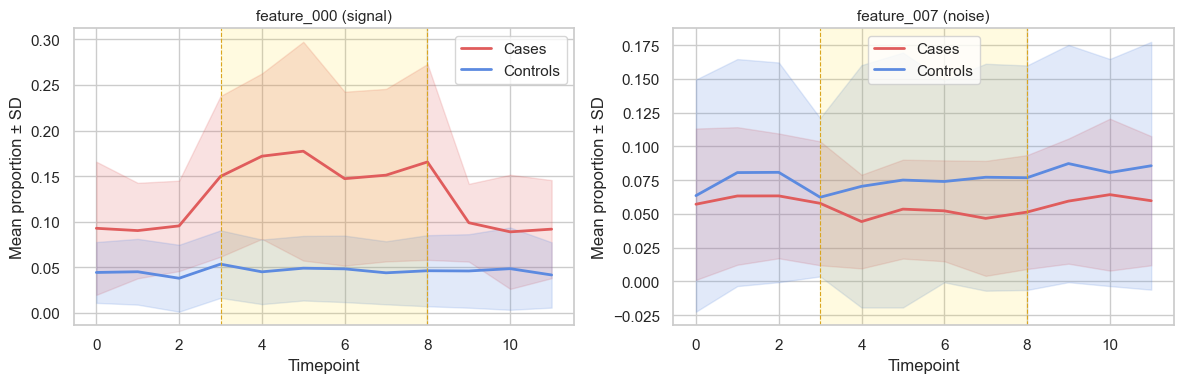

In [2]:
import matplotlib.patches as mpatches

case_color = '#e05c5c'
ctrl_color = '#5c8ae0'

motif_feats = df.attrs['motif_features']   # ['feature_000', 'feature_001', 'feature_002']
noise_feats = ['feature_005', 'feature_008', 'feature_012']
window = df.attrs['motif_window']          # (3, 8)

# ── Plot 1: individual trajectories ──────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharey=False)

for row_idx, feat_group in enumerate([motif_feats, noise_feats]):
    for col_idx, feat in enumerate(feat_group):
        ax = axes[row_idx, col_idx]
        feat_df = df[df['feature'] == feat]

        for subj, grp in feat_df.groupby('subject_id'):
            outcome = grp['outcome'].iloc[0]
            color = case_color if outcome == 1 else ctrl_color
            alpha = 0.55 if outcome == 1 else 0.30
            ax.plot(grp['timepoint'], grp['value'], color=color, alpha=alpha, lw=1.1)

        ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
        ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
        ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
        label = f'{feat}\n(signal)' if row_idx == 0 else f'{feat}\n(noise)'
        ax.set_title(label, fontsize=9)
        ax.set_xlabel('Timepoint')
        if col_idx == 0:
            ax.set_ylabel('Proportion')

case_patch = mpatches.Patch(color=case_color, label='Cases', alpha=0.7)
ctrl_patch = mpatches.Patch(color=ctrl_color, label='Controls', alpha=0.7)
window_patch = mpatches.Patch(color='gold', label='Motif window (truth)', alpha=0.4)
fig.legend(handles=[case_patch, ctrl_patch, window_patch],
           loc='upper right', bbox_to_anchor=(1.01, 0.98))
fig.suptitle('Individual trajectories: signal features (top) vs noise features (bottom)',
             fontsize=11, y=1.02)
plt.tight_layout()
plt.show()

# ── Plot 2: group mean ± SD ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_007'],
    ['feature_000 (signal)', 'feature_007 (noise)'],
):
    feat_df = df[df['feature'] == feat]
    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)
    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Mean proportion ± SD')
    ax.legend()

plt.tight_layout()
plt.show()

---
## 3  CLR Transform — For Visualisation ONLY (Not for Harbinger Input)

The **Centred Log-Ratio (CLR)** transform is the standard preprocessing step
for compositional data. Because all features sum to 1 at each timepoint, an
increase in any one feature forces the others down by the same amount. Raw
proportions therefore carry spurious negative correlations that reflect the
geometry of the simplex, not biology. CLR maps the data to unconstrained real
space where Euclidean distances are meaningful:

> CLR(xᵢ) = log(xᵢ) − mean(log(x₁), …, log(xₚ))

CLR is the right choice for **distance-based analyses** — PCA, Bray-Curtis
ordination, clustering — and it makes individual trajectory plots more visually
interpretable (the baseline becomes 0, and positive values signal relative
elevation).

**However, CLR should not be applied before `harbinger()`.** The log-ratio
transformation couples all features through a shared denominator (the geometric
mean). When one feature is genuinely elevated in cases at the motif timepoints,
the CLR denominator shifts for cases and controls differently, creating large
apparent case-control differences at timepoints where no real signal exists.
These artifacts contaminate the enrichment score — the metric harbinger uses to
rank windows — and cause the algorithm to select the wrong window. Running
harbinger on raw proportions avoids this entirely.

**In practice:**
- Run `harbinger()` on **raw proportions** (or raw counts / concentrations for
  non-compositional data).
- Apply CLR for **plotting** and for any distance-based analysis you want to
  do in parallel.
- For non-compositional data (cytokine concentrations, expression values,
  clinical measurements) no transformation is needed before `harbinger()`.

The code below applies CLR for visualization purposes, then runs
`tempo.check_baseline()` to verify that cases and controls are equivalent at
the first timepoint — the foundational assumption that makes TEMPO's results
interpretable as post-perturbation divergence rather than pre-existing difference.


Max absolute CLR row sum: 1.29e-14  (should be ~0)
CLR value range : [-10.374, 5.693]
Raw value range : [0.000, 0.429]

CLR is computed here for visualization (sections 5-6).
Harbinger (section 4) runs on raw proportions — see note above.

--- Baseline equivalence check ---
    feature  case_mean  ctrl_mean  mean_diff  p_value
feature_000   0.092719   0.044243   0.048477   0.0272

    feature  case_mean  ctrl_mean  p_value  significant
feature_000   0.092719   0.044243   0.0272         True
feature_008   0.051205   0.082452   0.0990        False
feature_001   0.076579   0.067219   0.1052        False
feature_011   0.083085   0.049829   0.1112        False
feature_004   0.047944   0.065800   0.2520        False
feature_002   0.054813   0.080516   0.2758        False
feature_013   0.070160   0.058568   0.3417        False
feature_006   0.073803   0.086807   0.5203        False
feature_005   0.053413   0.063285   0.5294        False
feature_009   0.082034   0.065352   0.5384        False


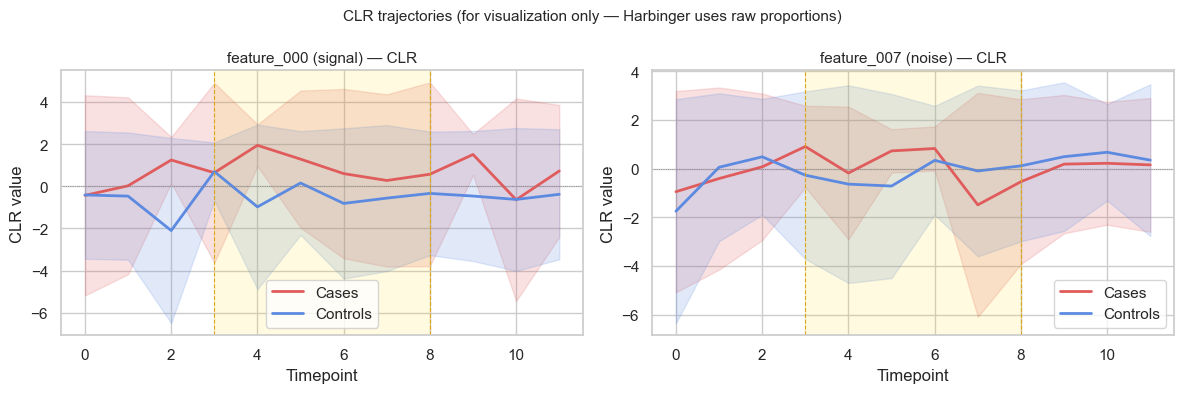

In [3]:
from tempo.preprocess import clr_transform

df_clr = clr_transform(df)

# Sanity check: CLR values sum to zero per (subject, timepoint)
clr_sums = df_clr.groupby(['subject_id', 'timepoint'])['value'].sum()
print(f"Max absolute CLR row sum: {clr_sums.abs().max():.2e}  (should be ~0)")
print(f"CLR value range : [{df_clr['value'].min():.3f}, {df_clr['value'].max():.3f}]")
print(f"Raw value range : [{df['value'].min():.3f}, {df['value'].max():.3f}]")
print()
print("CLR is computed here for visualization (sections 5-6).")
print("Harbinger (section 4) runs on raw proportions — see note above.")

# ── Baseline equivalence check ────────────────────────────────────────────────
print("\n--- Baseline equivalence check ---")
baseline_report = tempo.check_baseline(df)
sig_baseline = baseline_report[baseline_report['significant']]
if len(sig_baseline) == 0:
    print("No features show significant case/control differences at baseline (tp=0).")
    print("TEMPO's core assumption appears satisfied for this dataset.")
else:
    print(f"WARNING: {len(sig_baseline)} feature(s) differ significantly at baseline:")
    print(sig_baseline[['feature','case_mean','ctrl_mean','mean_diff','p_value']].to_string(index=False))
print()
print(baseline_report[['feature','case_mean','ctrl_mean','p_value','significant']].to_string(index=False))

# ── Plot CLR trajectories ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat, title in zip(
    axes,
    ['feature_000', 'feature_007'],
    ['feature_000 (signal) — CLR', 'feature_007 (noise) — CLR'],
):
    feat_df = df_clr[df_clr['feature'] == feat]
    for outcome, label, color in [(1, 'Cases', case_color), (0, 'Controls', ctrl_color)]:
        grp = feat_df[feat_df['outcome'] == outcome].groupby('timepoint')['value']
        means, stds = grp.mean(), grp.std()
        ax.plot(means.index, means.values, color=color, lw=2, label=label)
        ax.fill_between(means.index, means - stds, means + stds, color=color, alpha=0.18)
    ax.axvspan(window[0], window[1], alpha=0.12, color='gold')
    ax.axvline(window[0], color='goldenrod', lw=0.8, ls='--')
    ax.axvline(window[1], color='goldenrod', lw=0.8, ls='--')
    ax.axhline(0, color='gray', lw=0.6, ls=':')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('CLR value')
    ax.legend()

fig.suptitle('CLR trajectories (for visualization only — Harbinger uses raw proportions)',
             fontsize=11)
plt.tight_layout()
plt.show()

---
## 4  Harbinger Analysis

Harbinger analysis is the core of TEMPO. It uses STUMPY's `mstump` function —
a multidimensional pan-matrix profile — to find the time window where case
subjects simultaneously show the most conserved shared pattern of change.

**How the matrix profile works:** for a given window size *m*, the matrix
profile records, at each position in the time series, the distance to the
nearest matching subsequence elsewhere in the series. Low values indicate
motif positions (the same pattern appears repeatedly); high values indicate
discords (unique, unrepeated events). `mstump` extends this to a stack of time
series — one per case subject — and finds the window position where all cases
simultaneously agree on a shared pattern. The minimum of this cross-subject
matrix profile marks the strongest case-shared motif.

**Why this captures post-perturbation divergence:** because cases and controls
share the same baseline, any motif the matrix profile finds in the case group
that does not appear in controls represents genuine post-perturbation divergence
rather than a pre-existing difference. The enrichment score confirms this by
comparing case and control values at the discovered window.

**Multi-window scanning:** we pass `window_size_range=(3, 6)` to scan all
window lengths from 3 to 6 timepoints. The duration of a biological response
is rarely known in advance, and different features may respond on different
timescales. Scanning a range lets each feature select its own best window.

**Input data:** Harbinger runs on the **raw proportions** (`df`), not the CLR
values. This is important for compositional data — see section 3 for the
explanation. For non-compositional data, pass your data as-is.

**Enrichment score and p-value:** at the winning window, the enrichment score
is mean(case values) − mean(control values). A permutation test converts this
to a p-value by randomly shuffling case/control labels 999 times, building a
null distribution of scores expected if outcome assignment were random.

**Caveat:** scanning multiple window sizes introduces a mild selection bias.
Treat these p-values as exploratory; use a fixed, pre-specified window for
confirmatory testing (section 7).


In [4]:
# Run harbinger on raw proportions (NOT CLR — see section 3)
results = tempo.harbinger(df, window_size_range=(3, 6), top_k=15, n_permutations=999, seed=42)

print("Harbinger results (top 15 features, sorted by enrichment score):")
print(results[['feature', 'window_size', 'motif_window',
               'enrichment_score', 'p_value', 'q_value']].to_string(index=False))


Harbinger results (top 15 features, sorted by enrichment score):
    feature  window_size motif_window  enrichment_score  p_value  q_value
feature_000            6       (3, 8)          0.112861   0.0000   0.0000
feature_001            6       (3, 8)          0.054956   0.0020   0.0150
feature_002            3       (3, 5)          0.043403   0.0240   0.1200
feature_012            3       (0, 2)          0.019124   0.1832   0.6870
feature_011            3       (3, 5)          0.007180   0.3103   0.8682
feature_013            4       (0, 3)          0.007128   0.3473   0.8682
feature_009            3       (1, 3)          0.003832   0.4855   0.9760
feature_004            3      (9, 11)         -0.002560   0.6637   0.9760
feature_014            6       (0, 5)         -0.008984   0.8208   0.9760
feature_005            4       (5, 8)         -0.011389   0.8619   0.9760
feature_003            5       (0, 4)         -0.012156   0.7648   0.9760
feature_007            5       (0, 4)         -

---
## 5  Visualising the Motifs

`tempo.plot_motifs()` draws individual subject trajectories overlaid with group
mean ± 1 SD ribbons for cases and controls, with the discovered motif window
shaded in gold. This is the most direct way to visually confirm that Harbinger
found a real signal rather than a statistical artefact.

For a genuine trajectory motif, you should see: cases and controls overlapping
before the window (shared baseline), the case ribbon diverging from controls
inside the window (the post-perturbation pattern), and potentially a return
toward baseline after the window. Noise features should show overlapping
ribbons throughout, with no systematic divergence inside the gold region.

The plot uses CLR-transformed values — positive values mean the feature is
elevated relative to the geometric mean composition at that timepoint, negative
means suppressed. The baseline (CLR = 0) corresponds to a feature being exactly
at its geometric mean proportion.


Top 4 features : ['feature_000', 'feature_001', 'feature_002', 'feature_012']
Motif window   : (3, 8)


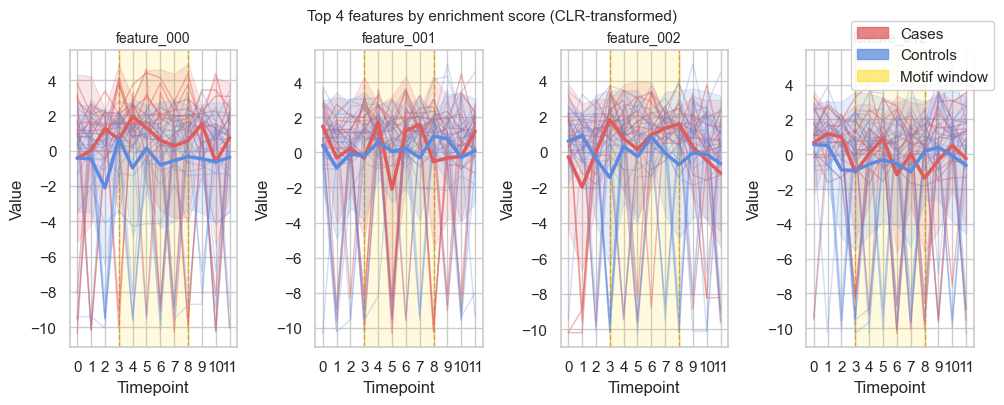

In [5]:
top_features = results['feature'].head(4).tolist()
top_window = results['motif_window'].iloc[0]

print(f"Top 4 features : {top_features}")
print(f"Motif window   : {top_window}")

fig = tempo.plot_motifs(df_clr, features=top_features, motif_window=top_window)
fig.suptitle('Top 4 features by enrichment score (CLR-transformed)',
             fontsize=11, y=1.01)
plt.show()

---
## 6  Enrichment Summary

`tempo.plot_enrichment()` gives a two-panel overview of the full Harbinger
results table.

The **left panel** shows enrichment scores as horizontal bars. Features with a
permutation p-value below 0.05 are coloured red (significant); others are grey.
Significance stars (* p < 0.05, ** p < 0.01, *** p < 0.001) are appended to
feature labels for quick visual scanning.

The **right panel** shows −log₁₀(p-value). The dashed red line at
−log₁₀(0.05) ≈ 1.30 marks the significance threshold. Bars clearing this line
are significant. This panel makes it easy to compare the strength of evidence
across features, not just which side of the binary threshold they fall on.

Together, the two panels answer both "which features show a case-enriched
trajectory?" and "how strong is the evidence?". Features at the top of both
panels are the strongest candidates for follow-up mechanistic study or
validation in an independent cohort.


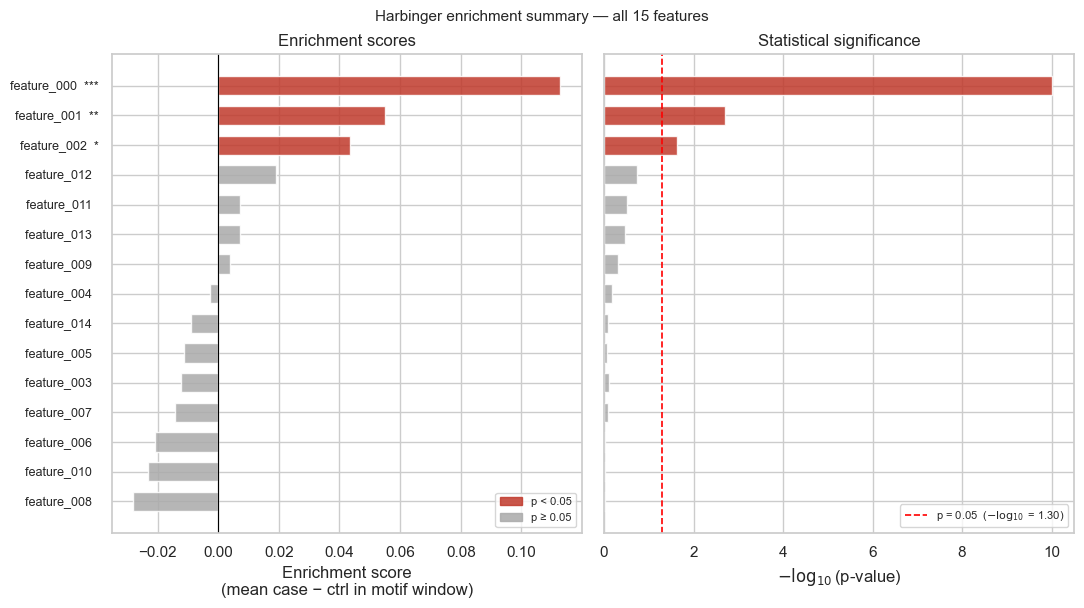

In [6]:
fig = tempo.plot_enrichment(results, top_k=15)
fig.suptitle('Harbinger enrichment summary — all 15 features',
             fontsize=11, y=1.01)
plt.show()

---
## 7  Follow-up Statistical Testing with a Fixed Window

The permutation test inside Harbinger is run on the data-adaptive window
selected by the matrix profile. This is appropriate for discovery, but the
p-values carry a selection effect — we tested many windows and reported the best.

For confirmatory analysis, best practice is to fix the window in advance based
on prior biological knowledge (e.g. the known duration of an acute immune
response) or a pre-registered analysis plan, then test only that window.
`tempo.permutation_test()` provides exactly this: a standalone permutation test
on a single, pre-specified (feature, window) pair. Because there is no window
selection involved, the p-value is more conservative and more directly
interpretable as the probability of observing this level of case enrichment by
chance under random outcome assignment.

Here we test the top-ranked feature at the window discovered by Harbinger. In
a rigorous two-stage analysis, the window would be specified independently of
the data being tested — for example, from a prior study or a held-out cohort.


Confirmatory permutation test for feature_000 at window (3, 8):
  observed_score: 0.1129
  p_value: 0.0000
  null_mean: -0.0021
  null_sd: 0.0262
  n_permutations: 999


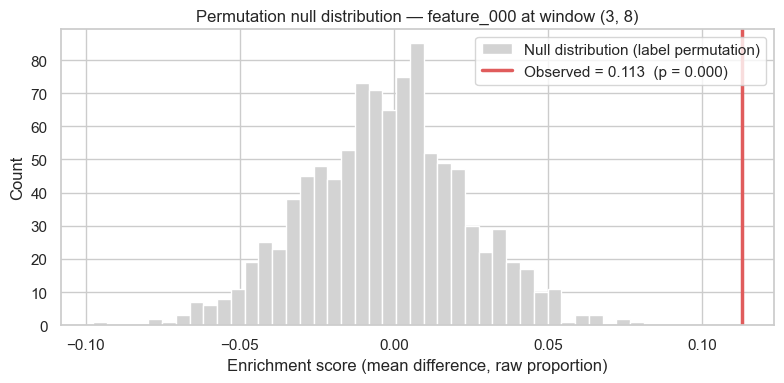

In [ ]:
top_feature = results['feature'].iloc[0]
discovered_window = results['motif_window'].iloc[0]

print(f"Confirmatory permutation test for {top_feature} at window {discovered_window}:")
# Use same data as harbinger (raw proportions)
perm_result = tempo.permutation_test(
    df, top_feature, discovered_window, n_permutations=999, seed=42
)
for k, v in perm_result.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# ── Null distribution plot ────────────────────────────────────────────────────
rng = np.random.default_rng(42)
null_sample = rng.normal(perm_result['null_mean'], perm_result['null_sd'], 999)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(null_sample, bins=40, color='lightgray', edgecolor='white',
        label='Null distribution (label permutation)')
ax.axvline(perm_result['observed_score'], color=case_color, lw=2.5,
           label=f"Observed = {perm_result['observed_score']:.3f}  "
                 f"(p = {perm_result['p_value']:.3f})")
ax.set_xlabel('Enrichment score (mean difference, raw proportion)')
ax.set_ylabel('Count')
ax.set_title(f'Permutation null distribution — {top_feature} at window {discovered_window}')
ax.legend()
plt.tight_layout()
plt.show()

---
## 8  Evaluating Against Ground Truth

In a real study we do not know which features carry signal or exactly when the
response window falls — that is what we are trying to discover. But because this
is a simulated dataset, `df.attrs` records the planted ground truth, letting us
measure how well Harbinger recovered it using three metrics:

**Feature recall** — what fraction of the true signal features were detected?
A recall of 1.0 means all three were found; 0.67 means two out of three.

**Feature precision** — of the features flagged as significant, what fraction
were genuinely signal-carrying? High precision means few false positives.

**Window Jaccard** — how much do the detected and true windows overlap?
Jaccard = |detected ∩ true| / |detected ∪ true|, treating each timepoint as a
set element. 1.0 = exact match; 0.0 = no overlap.

In practice, recall matters more than precision for hypothesis generation — it
is better to follow up on a few false positives than to miss real signal.
Precision matters more when downstream validation is expensive or when the
results will be used to make a clinical decision.


Significant features (q < 0.05) : ['feature_000', 'feature_001']
Detected window (top feature)   : (3, 8)
True signal features            : ['feature_000', 'feature_001', 'feature_002']
True response window            : (3, 8)

All results with p and q values:
    feature  p_value  q_value
feature_000   0.0000   0.0000
feature_001   0.0020   0.0150
feature_002   0.0240   0.1200
feature_012   0.1832   0.6870
feature_011   0.3103   0.8682
feature_013   0.3473   0.8682
feature_009   0.4855   0.9760
feature_004   0.6637   0.9760
feature_014   0.8208   0.9760
feature_005   0.8619   0.9760
feature_003   0.7648   0.9760
feature_007   0.8208   0.9760
feature_006   0.9349   0.9760
feature_010   0.9419   0.9760
feature_008   0.9760   0.9760

Evaluation report:
  feature_recall: 0.667
  feature_precision: 1.000
  window_jaccard: 1.000
  true_features: ['feature_001', 'feature_000', 'feature_002']
  detected_features: ['feature_001', 'feature_000']
  true_window: (3, 8)
  detected_window: (3, 8)


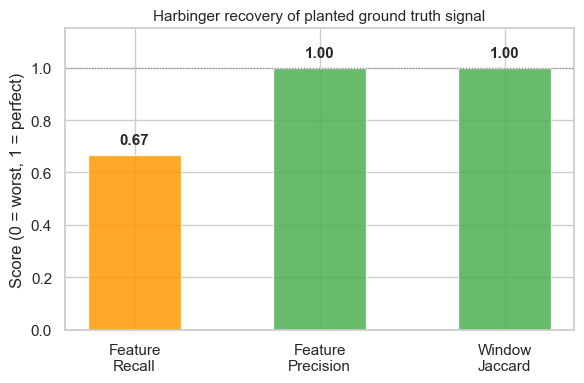

In [ ]:
# Use FDR-adjusted q_value < 0.05 as the significance threshold.
# q_value is Benjamini-Hochberg corrected across all features tested —
# more appropriate than raw p_value when screening many features at once.
sig_features = results[results['q_value'] < 0.05]['feature'].tolist()
detected_window = results['motif_window'].iloc[0]

print(f"Significant features (q < 0.05) : {sig_features}")
print(f"Detected window (top feature)   : {detected_window}")
print(f"True signal features            : {df.attrs['motif_features']}")
print(f"True response window            : {df.attrs['motif_window']}")
print("\nAll results with p and q values:")
print(results[['feature','p_value','q_value']].to_string(index=False))
print()

report = simulate.evaluation_report(
    detected_features=sig_features,
    detected_window=detected_window,
    df=df,
)
print("Evaluation report:")
for k, v in report.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")

# ── Bar chart of the three metrics ───────────────────────────────────────────
metrics = ['feature_recall', 'feature_precision', 'window_jaccard']
labels  = ['Feature\nRecall', 'Feature\nPrecision', 'Window\nJaccard']
values  = [report[m] for m in metrics]
colors  = ['#4caf50' if v >= 0.8 else '#ff9800' if v >= 0.5 else '#f44336'
           for v in values]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=colors, alpha=0.85, width=0.5)
ax.set_ylim(0, 1.15)
ax.axhline(1.0, color='gray', lw=0.8, ls=':')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, val + 0.03,
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_title('Harbinger recovery of planted ground truth signal', fontsize=11)
ax.set_ylabel('Score (0 = worst, 1 = perfect)')
plt.tight_layout()
plt.show()

---
## 9  Non-Compositional Data

All previous sections used compositional measurements — values that sum to 1 at
each timepoint. TEMPO works equally well on non-compositional data such as:

- **Flow cytometry** — MFI (Median Fluorescence Intensity) values, cell counts,
  or percentage-positive readouts from a surface marker panel
- **Cytokine concentrations** — absolute or relative protein levels from a
  multiplex assay (Luminex, Olink, ELISA)
- **Gene expression** — log2-normalized RNA-seq counts or microarray intensities
- **Clinical lab measurements** — haematology, metabolic panels, vital signs

For these data types, CLR transformation is neither necessary nor appropriate.
Pass your data directly to `harbinger()` with no preprocessing. The matrix
profile z-normalises each window internally, so the absolute scale and baseline
level of your measurements do not affect motif detection.

The only preprocessing you might consider for non-compositional data is
**z-score normalization per feature** (subtract the feature mean across all
subjects and timepoints, divide by the standard deviation) when features are on
very different scales and you want the enrichment score to be interpretable in
common units. But this is optional — harbinger works correctly on raw values.

The example below generates a simulated dataset representing 10 immune markers
measured over 12 timepoints in 40 subjects. Three markers carry a step-change
motif in cases between timepoints 3 and 8 (e.g. a sustained post-perturbation
elevation). The workflow is identical to the compositional case, minus the CLR
step and the baseline check note.


In [ ]:
# ── Simulate non-compositional data ──────────────────────────────────────────
# Framing: 10 immune markers (e.g. MFI from a cytometry panel)
# measured over 12 timepoints post-perturbation in 40 subjects.
df_nc = simulate.simulate_continuous(
    n_subjects=40, n_timepoints=12, n_features=10, n_cases=15,
    motif_features=[0, 1, 2],   # markers 0-2 carry the signal
    motif_window=(3, 8),         # signal present at timepoints 3-8
    motif_type='step',           # sustained elevation (not a spike)
    motif_strength=2.5,          # effect size in raw units
    noise_sd=0.5,
    baseline_mean=0.0,
    seed=42,
)

print(f"Shape           : {df_nc.shape}")
print(f"Value range     : [{df_nc['value'].min():.2f}, {df_nc['value'].max():.2f}]")
print("Sums to 1?      : No — values are unbounded (non-compositional)")
print(f"Subjects        : {df_nc['subject_id'].nunique()} "
      f"({(df_nc['outcome']==1).groupby(df_nc['subject_id']).first().sum()} cases)")
print()
print("No CLR or other transformation needed — passing raw values to harbinger().")

Shape           : (4800, 5)
Value range     : [-3.80, 5.17]
Sums to 1?      : No — values are unbounded (non-compositional)
Subjects        : 40 (15 cases)

No CLR or other transformation needed — passing raw values to harbinger().


In [10]:
# ── Run Harbinger on raw non-compositional data ───────────────────────────────
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    results_nc = tempo.harbinger(
        df_nc, window_size_range=(3, 6), top_k=10, n_permutations=999, seed=42
    )

print("Harbinger results (non-compositional data):")
print(results_nc[['feature', 'window_size', 'motif_window',
                   'enrichment_score', 'p_value', 'q_value']].to_string(index=False))
print()

sig_nc = results_nc[results_nc['q_value'] < 0.05]['feature'].tolist()
top_win_nc = results_nc.iloc[0]['motif_window']
rep_nc = simulate.evaluation_report(sig_nc, top_win_nc, df_nc)
print(f"Significant features (q < 0.05) : {sig_nc}")
print(f"Detected window                 : {top_win_nc}  (true: (3, 8))")
print(f"Feature recall={rep_nc['feature_recall']:.3f}  "
      f"precision={rep_nc['feature_precision']:.3f}  "
      f"window Jaccard={rep_nc['window_jaccard']:.3f}")

Harbinger results (non-compositional data):
    feature  window_size motif_window  enrichment_score  p_value  q_value
feature_002            5       (3, 7)          3.040413   0.0000   0.0000
feature_000            5       (4, 8)          1.984272   0.0000   0.0000
feature_001            6       (3, 8)          1.966892   0.0000   0.0000
feature_009            3       (3, 5)          0.477042   0.1241   0.2602
feature_007            4       (4, 7)          0.469671   0.1301   0.2602
feature_006            5       (5, 9)          0.035479   0.5776   0.9219
feature_005            5       (3, 7)         -0.230807   0.8308   0.9219
feature_008            5       (1, 5)         -0.268912   0.8348   0.9219
feature_004            4       (2, 5)         -0.309474   0.8789   0.9219
feature_003            3       (0, 2)         -0.432615   0.9219   0.9219

Significant features (q < 0.05) : ['feature_002', 'feature_000', 'feature_001']
Detected window                 : (3, 7)  (true: (3, 8))
Feat

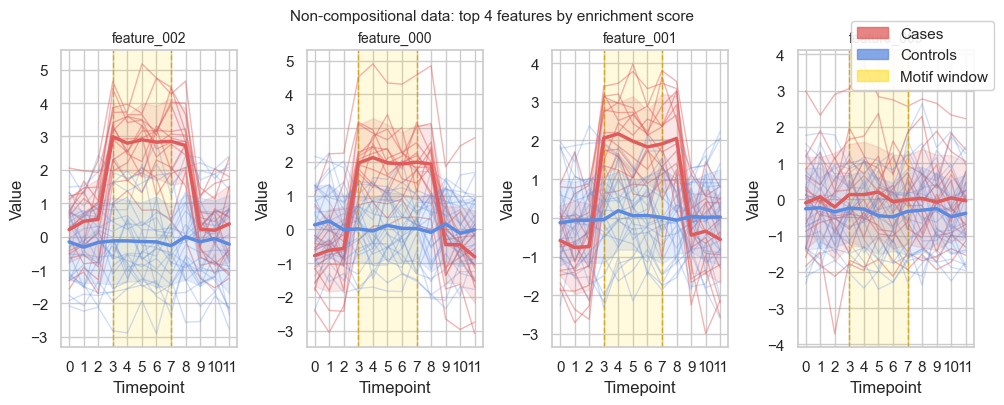

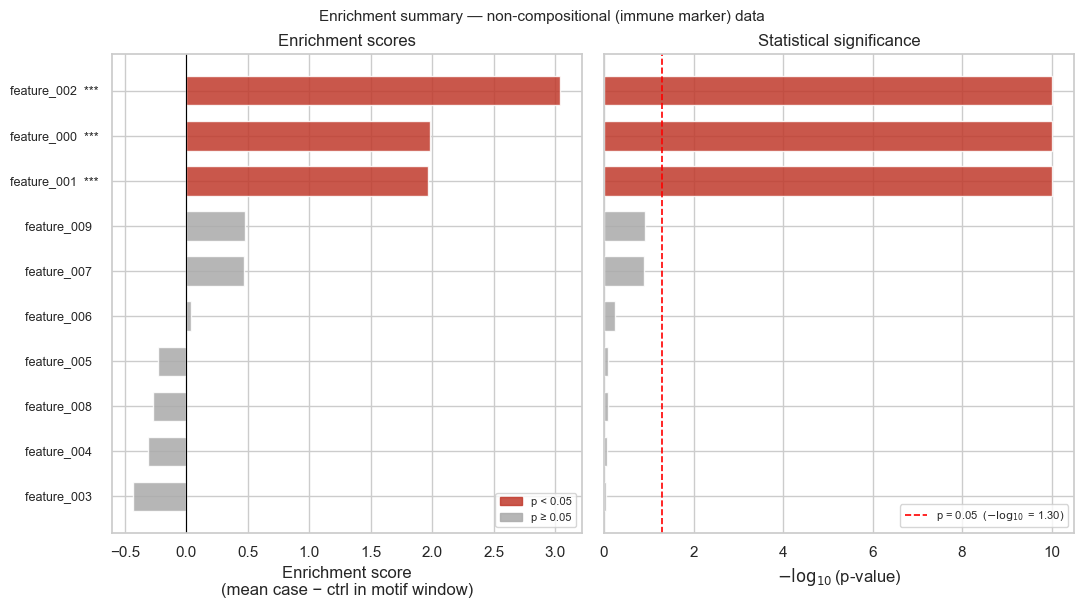

In [11]:
# ── Visualise motifs (raw values — no CLR needed) ─────────────────────────────
fig = tempo.plot_motifs(
    df_nc,
    features=results_nc['feature'].head(4).tolist(),
    motif_window=top_win_nc,
)
fig.suptitle('Non-compositional data: top 4 features by enrichment score',
             fontsize=11, y=1.01)
plt.show()

fig = tempo.plot_enrichment(results_nc, top_k=10)
fig.suptitle('Enrichment summary — non-compositional (immune marker) data',
             fontsize=11, y=1.01)
plt.show()

---
## 10  Continuous and Ranked Outcomes

Not every longitudinal study produces a clean binary case/control label.
Common continuous or ranked outcomes include:

- A **clinical severity score** at follow-up (e.g. a composite disease activity index,
  a validated questionnaire score, a continuous physiological measurement)
- A **biomarker level** at a fixed post-perturbation timepoint (e.g. peak viral load,
  antibody titre, fasting glucose at week 12)
- A **treatment response score** (e.g. percent change from baseline in tumour volume,
  a ranked RECIST response category)

TEMPO supports continuous outcomes in two complementary ways:

**1. Binarization at a threshold.** Split subjects at the median (or a clinically
meaningful cutoff) to get a 0/1 label, then run `harbinger()` as normal. The
enrichment score is the mean difference between high-outcome and low-outcome
subjects. This is the simplest and most robust approach for discovery.

**2. Multi-method enrichment scoring via `enrichment_score()`.** Once a motif
window has been identified — either by harbinger or from prior knowledge — the
three scoring methods offer different perspectives on the case/control separation:

| Method | Null value | Best when |
|---|---|---|
| `mean_difference` | 0 | Simple, interpretable; good all-round choice |
| `auc` | 0.5 | Outcomes are noisy; you care about rank-ordering, not magnitude |
| `gsea` | 0 | Subjects vary in how strongly they express the motif; rewards top-clustering |

The GSEA-style score is most powerful when a minority of subjects show a very
strong motif signal and the rest are closer to noise — analogous to gene-set
enrichment analysis where only a fraction of set members are truly driving the
signal.

Below we simulate a dataset with a continuous outcome, binarize at the median
for harbinger, then compare all three scoring methods on the top-ranked feature.


Outcome range  : [-0.593, 1.359]
Outcome mean   : 0.453
Outcome median : 0.532



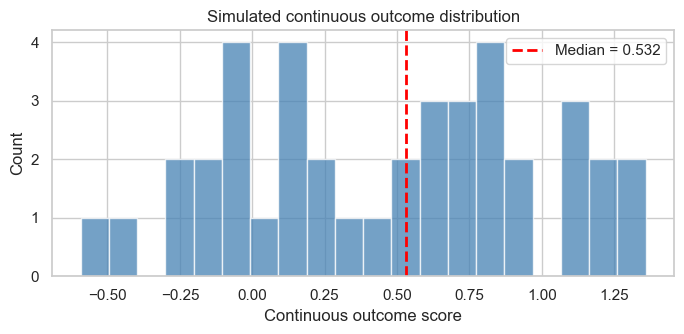

In [12]:
# ── Simulate with continuous outcome ─────────────────────────────────────────
# Framing: 40 subjects measured over 12 timepoints; each receives a continuous
# outcome score (e.g. a composite disease index at the end of follow-up).
# Cases (high-outcome subjects) show a trajectory motif at timepoints 3-8.

df_cont = simulate.simulate_continuous(
    n_subjects=40, n_timepoints=12, n_features=10, n_cases=20,
    motif_features=[0, 1, 2], motif_window=(3, 8),
    motif_type='step', motif_strength=2.5, noise_sd=0.5,
    outcome_type='continuous',   # outcome becomes a continuous float
    seed=42,
)

# Show the continuous outcome distribution
subject_outcomes = df_cont[['subject_id', 'outcome']].drop_duplicates('subject_id')
print(f"Outcome range  : [{subject_outcomes['outcome'].min():.3f}, "
      f"{subject_outcomes['outcome'].max():.3f}]")
print(f"Outcome mean   : {subject_outcomes['outcome'].mean():.3f}")
print(f"Outcome median : {subject_outcomes['outcome'].median():.3f}")
print()

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.hist(subject_outcomes['outcome'], bins=20, color='steelblue', alpha=0.75, edgecolor='white')
ax.axvline(subject_outcomes['outcome'].median(), color='red', lw=2, ls='--',
           label=f"Median = {subject_outcomes['outcome'].median():.3f}")
ax.set_xlabel('Continuous outcome score')
ax.set_ylabel('Count')
ax.set_title('Simulated continuous outcome distribution')
ax.legend()
plt.tight_layout()
plt.show()

Binarized at median = 0.532  |  high-outcome n=20  low-outcome n=20



Harbinger results (binarized continuous outcome):
    feature  window_size motif_window  enrichment_score  p_value  q_value
feature_002            6       (3, 8)          2.148556   0.0000   0.0000
feature_000            3       (6, 8)          2.124119   0.0000   0.0000
feature_001            4       (3, 6)          1.958464   0.0000   0.0000
feature_009            5       (1, 5)          0.208763   0.3463   0.8148
feature_007            3       (6, 8)          0.025930   0.5015   0.8148
feature_008            4       (0, 3)         -0.018528   0.5596   0.8148
feature_003            6       (0, 5)         -0.093418   0.6697   0.8148
feature_005            3       (7, 9)         -0.106094   0.6957   0.8148
feature_006            4       (0, 3)         -0.187513   0.7948   0.8148
feature_004            3       (0, 2)         -0.209176   0.8148   0.8148

Enrichment scores for feature_002 at window (3, 8):
  mean_difference     : 2.1486
  auc                 : 0.8500
  gsea              

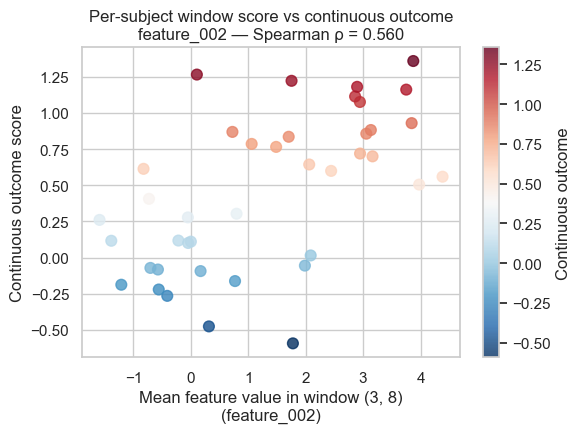

In [13]:
import warnings

# ── Binarize at median → run harbinger ────────────────────────────────────────
# For harbinger we need binary labels. We split at the median outcome score:
# subjects above median → high-outcome (1); below → low-outcome (0).
threshold_cont = float(subject_outcomes['outcome'].median())
binary_map = (subject_outcomes.set_index('subject_id')['outcome'] >= threshold_cont).astype(int)
df_cont['outcome_binary'] = df_cont['subject_id'].map(binary_map)

print(f"Binarized at median = {threshold_cont:.3f}  |  "
      f"high-outcome n={binary_map.sum()}  low-outcome n={len(binary_map)-binary_map.sum()}")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    results_cont = tempo.harbinger(
        df_cont, outcome_col='outcome_binary',
        window_size_range=(3, 6), top_k=10, n_permutations=999, seed=42,
    )

print("\nHarbinger results (binarized continuous outcome):")
print(results_cont[['feature', 'window_size', 'motif_window',
                     'enrichment_score', 'p_value', 'q_value']].to_string(index=False))

# ── Compare all three enrichment scoring methods ──────────────────────────────
top_feat_cont = results_cont['feature'].iloc[0]
top_win_cont  = results_cont['motif_window'].iloc[0]

print(f"\nEnrichment scores for {top_feat_cont} at window {top_win_cont}:")
for method in ['mean_difference', 'auc', 'gsea']:
    score = tempo.enrichment_score(df_cont, top_feat_cont, top_win_cont,
                                   outcome_col='outcome_binary', method=method)
    print(f"  {method:20s}: {score:.4f}")

# ── Scatter: continuous outcome vs per-subject window score ───────────────────
win_df = df_cont[(df_cont['feature'] == top_feat_cont) &
                 (df_cont['timepoint'].between(top_win_cont[0], top_win_cont[1]))]
subj_win = win_df.groupby('subject_id')['value'].mean().reset_index()
subj_win.columns = ['subject_id', 'window_score']
scatter_df = subj_win.merge(subject_outcomes, on='subject_id')

fig, ax = plt.subplots(figsize=(6, 4.5))
sc = ax.scatter(scatter_df['window_score'], scatter_df['outcome'],
                c=scatter_df['outcome'], cmap='RdBu_r', alpha=0.8, s=60)
plt.colorbar(sc, ax=ax, label='Continuous outcome')
ax.set_xlabel(f'Mean feature value in window {top_win_cont}\n({top_feat_cont})')
ax.set_ylabel('Continuous outcome score')
ax.set_title(f'Per-subject window score vs continuous outcome\n'
             f'{top_feat_cont} — Spearman ρ = '
             f'{scatter_df["window_score"].corr(scatter_df["outcome"], method="spearman"):.3f}')
plt.tight_layout()
plt.show()

---
## 11  Survival-Integrated Analysis

The most clinically natural outcome in many cohort studies is **time-to-event**:
when did the subject develop the outcome of interest — and did they ever develop
it before the study ended (or were they lost to follow-up)?

Examples:
- Time to **transplant rejection** after a solid organ transplant
- Time to **relapse** after cancer treatment
- Time to **seroconversion** after a vaccination challenge
- Days to **first fever** after a dietary intervention

`tempo.survival_test()` connects trajectory motifs to time-to-event outcomes.
Subjects are stratified at the **median motif score** — those above are labelled
"motif-positive" (showed a strong case-like trajectory pattern); those below are
"motif-negative". The survival curves of the two groups are then compared.

Two statistical methods are available:

**Log-rank test** (via `scipy.stats.logrank`): a non-parametric test for equality
of survival curves. It is threshold-free — the test integrates over all event
times rather than comparing at a single point. Works without any optional
dependencies. Use this when you want a significance test with good power under
the proportional hazards assumption.

**Cox proportional hazards** (via `lifelines`, optional): instead of stratifying
at the median, the continuous motif score is used directly as a covariate. The
hazard ratio (HR) tells you how much the event risk changes per one-unit increase
in motif score. This is more informative than the log-rank test when the
relationship between motif strength and survival is graded. Install lifelines with
`pip install tempo-bio[survival]`.

`tempo.plot_survival()` draws the Kaplan-Meier survival curves for the two
motif-stratified groups, with censored observations marked as "+" ticks. No
external library is required — the KM estimator is implemented in pure numpy.


In [14]:
# ── Simulate with survival (time-to-event) outcome ───────────────────────────
# Framing: 60 subjects, 12 timepoints, 10 immune markers.
# 25 subjects eventually experience the event (event=1); 35 are censored (event=0).
# Subjects who experience the event show a trajectory motif at timepoints 3-8.

df_surv = simulate.simulate_continuous(
    n_subjects=60, n_timepoints=12, n_features=10, n_cases=25,
    motif_features=[0, 1, 2], motif_window=(3, 8),
    motif_type='step', motif_strength=2.5, noise_sd=0.5,
    outcome_type='survival',     # adds 'time_to_event' column; outcome = event indicator
    seed=42,
)

print(f"Shape           : {df_surv.shape}")
print(f"Columns         : {list(df_surv.columns)}")
n_events = df_surv[['subject_id', 'outcome']].drop_duplicates()['outcome'].sum()
n_total = df_surv['subject_id'].nunique()
print(f"Subjects        : {n_total}  ({int(n_events)} events, {n_total-int(n_events)} censored)")
print(f"Time range      : {df_surv['time_to_event'].min()}–{df_surv['time_to_event'].max()}")
print()

# Run harbinger using the binary event indicator as the outcome column.
# This discovers which features show a trajectory motif in event subjects.
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    results_surv = tempo.harbinger(
        df_surv, window_size_range=(3, 6), top_k=10, n_permutations=999, seed=42,
    )

print("Harbinger results (event indicator as outcome):")
print(results_surv[['feature', 'window_size', 'motif_window',
                     'enrichment_score', 'p_value', 'q_value']].to_string(index=False))

Shape           : (7200, 6)
Columns         : ['subject_id', 'timepoint', 'feature', 'value', 'outcome', 'time_to_event']
Subjects        : 60  (25 events, 35 censored)
Time range      : 6–23



Harbinger results (event indicator as outcome):
    feature  window_size motif_window  enrichment_score  p_value  q_value
feature_002            3       (6, 8)          2.718929   0.0000   0.0000
feature_001            6       (3, 8)          2.270214   0.0000   0.0000
feature_000            6       (3, 8)          2.003387   0.0000   0.0000
feature_007            4       (3, 6)          0.483994   0.0521   0.1302
feature_009            3       (7, 9)          0.406582   0.0951   0.1902
feature_003            3       (0, 2)          0.028083   0.5385   0.7730
feature_004            5       (1, 5)          0.001387   0.5566   0.7730
feature_008            4       (0, 3)         -0.028901   0.6226   0.7730
feature_006            4       (0, 3)         -0.088398   0.6957   0.7730
feature_005            4       (0, 3)         -0.518174   0.9870   0.9870


In [15]:
# ── survival_test: log-rank and Cox ───────────────────────────────────────────
top_feat_surv = results_surv['feature'].iloc[0]
top_win_surv  = results_surv['motif_window'].iloc[0]

print(f"Top feature     : {top_feat_surv}")
print(f"Motif window    : {top_win_surv}")
print()

# Log-rank test — stratify at median motif score, compare survival curves
lr = tempo.survival_test(df_surv, top_feat_surv, top_win_surv, method='logrank')
print("Log-rank test:")
for k, v in lr.items():
    print(f"  {k}: {v}")

print()

# Cox proportional hazards — uses continuous motif score directly (no binning)
try:
    cox = tempo.survival_test(df_surv, top_feat_surv, top_win_surv, method='cox')
    print("Cox PH model (continuous motif score as covariate):")
    for k, v in cox.items():
        print(f"  {k}: {v}")
except ImportError as e:
    print(f"lifelines not installed — skipping Cox model ({e})")
    print("Install with: pip install tempo-bio[survival]")

Top feature     : feature_002
Motif window    : (6, 8)

Log-rank test:
  statistic: 5.579361
  p_value: 0.0
  method: logrank
  feature: feature_002
  motif_window: (6, 8)
  n_motif_positive: 30
  n_motif_negative: 30
  score_threshold: 0.551606

lifelines not installed — skipping Cox model (Cox proportional hazards requires lifelines. Install it with: pip install tempo-bio[survival])
Install with: pip install tempo-bio[survival]


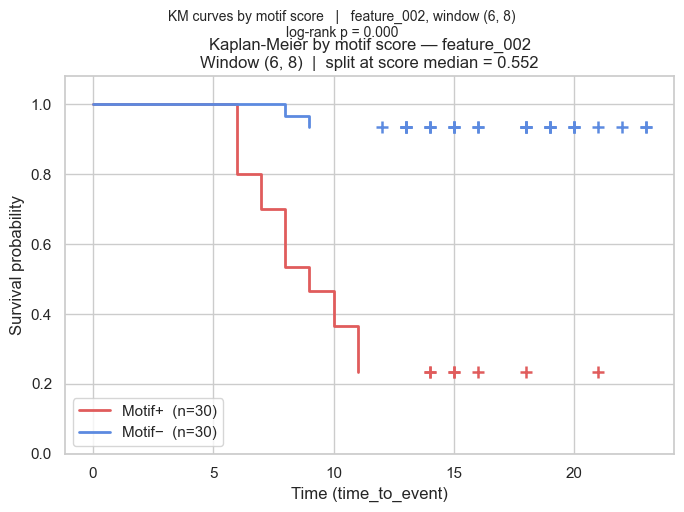

Significant features (q < 0.05) : ['feature_002', 'feature_001', 'feature_000']
Detected window                 : (6, 8)  (true: (3, 8))
Feature recall    = 1.000
Feature precision = 1.000
Window Jaccard    = 0.500


In [16]:
# ── Kaplan-Meier plot ─────────────────────────────────────────────────────────
# plot_survival() uses a pure-numpy KM estimator — no lifelines needed.
# Subjects are split at the median motif score (Motif+ / Motif−).
# Censored observations are marked with '+' ticks on the survival curves.

fig = tempo.plot_survival(
    df_surv, top_feat_surv, top_win_surv,
    time_col='time_to_event', event_col='outcome',
)
fig.suptitle(
    f'KM curves by motif score   |   {top_feat_surv}, window {top_win_surv}\n'
    f'log-rank p = {lr["p_value"]:.3f}',
    fontsize=10, y=1.02,
)
plt.show()

# ── Evaluation against ground truth ───────────────────────────────────────────
sig_surv = results_surv[results_surv['q_value'] < 0.05]['feature'].tolist()
top_det_win = results_surv.iloc[0]['motif_window']
rep_surv = simulate.evaluation_report(sig_surv, top_det_win, df_surv)
print(f"Significant features (q < 0.05) : {sig_surv}")
print(f"Detected window                 : {top_det_win}  (true: (3, 8))")
print(f"Feature recall    = {rep_surv['feature_recall']:.3f}")
print(f"Feature precision = {rep_surv['feature_precision']:.3f}")
print(f"Window Jaccard    = {rep_surv['window_jaccard']:.3f}")